# Imports

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation, Reshape, LSTM, Bidirectional
)
from tensorflow.keras.optimizers import Adam

In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## import data

In [3]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

In [4]:
train

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330958,TRAIN_330959.jpg,COUTINHO DESA
330959,TRAIN_330960.jpg,MOURAD


In [5]:
valid

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
...,...,...
41365,VALIDATION_41366.jpg,CHAILLAN
41366,VALIDATION_41367.jpg,BAROUH
41367,VALIDATION_41368.jpg,MAXENCE
41368,VALIDATION_41369.jpg,HAMELIN


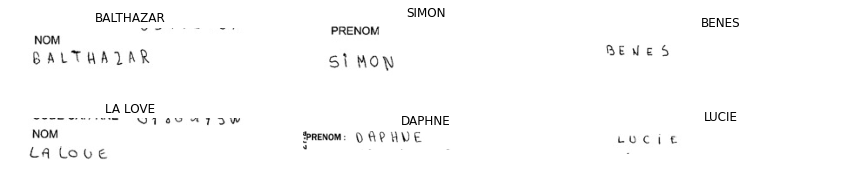

In [6]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# Cleaning Data

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [8]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41292 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [9]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [10]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

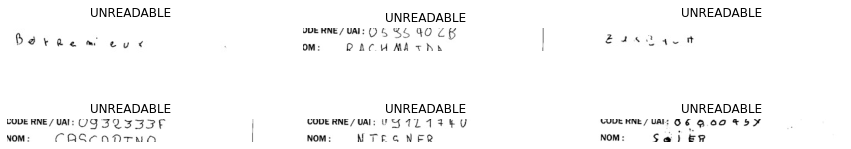

In [11]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [12]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [13]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

# Pre-processing Data

In [15]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [16]:
train_size = 30000
valid_size= 3000

In [17]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [18]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [19]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

# Convert labels to numerical format and back

Since the model is trained using **CTC Loss**, the labels need to be in **numerical form**, and their lengths must be adjusted during training.


In [20]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [21]:
name = 'NUR HIKMAH'
print(name, '\n',label_to_num(name))

NUR HIKMAH 
 [13 20 17 28  7  8 10 12  0  7]


In [22]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [23]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [24]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


# Model Building

This model uses CNN to identify important features from handwritten images, such as patterns and textures. Then, RNN is used to understand the sequence of characters or words in these handwritten images.

In [25]:
# Input layer: expects grayscale images of shape (256, 64, 1)
input_data = Input(shape=(256, 64, 1), name='input')

# First Convolutional Block
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)  
inner = Activation('relu')(inner) 
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  

# Second Convolutional Block
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  #
inner = BatchNormalization()(inner) 
inner = Activation('relu')(inner)  
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner) 
inner = Dropout(0.3)(inner)  

# Third Convolutional Block
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # 128 filters, 3x3 kernel
inner = BatchNormalization()(inner) 
inner = Activation('relu')(inner)  
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  
inner = Dropout(0.3)(inner) 

# Reshape layer to prepare for RNN input
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)  # Reshape to (64, 1024)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner) 

# Recurrent Neural Network (RNN) Layers
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)  # Bidirectional LSTM with 256 units, returns sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)  # Another Bidirectional LSTM with 256 units

# Output layer
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner) 
y_pred = Activation('softmax', name='softmax')(inner)  

# Model definition
model = Model(inputs=input_data, outputs=y_pred)  
model.summary() 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)      


# Role of CTC Loss

**CTC loss** allows the model to predict the sequence of characters in an image without requiring explicit information about the position of each character. It is suitable for handling variations in handwriting length or uncertainty in the placement of handwritten characters.

In [26]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [27]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

# Compile model

In [28]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

# Model Training

In [29]:
with tf.device('/GPU:0'):
    history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                          validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                          epochs=60, batch_size=128)

Epoch 1/60
235/235 [==============================] - 35s 147ms/step - loss: 24.2010 - val_loss: 20.9143
Epoch 2/60
235/235 [==============================] - 33s 140ms/step - loss: 20.1742 - val_loss: 20.1970
Epoch 3/60
235/235 [==============================] - 33s 140ms/step - loss: 19.8077 - val_loss: 19.7280
Epoch 4/60
235/235 [==============================] - 33s 140ms/step - loss: 19.1340 - val_loss: 18.7709
Epoch 5/60
235/235 [==============================] - 33s 140ms/step - loss: 17.7509 - val_loss: 16.6844
Epoch 6/60
235/235 [==============================] - 33s 140ms/step - loss: 15.7754 - val_loss: 14.3003
Epoch 7/60
235/235 [==============================] - 33s 141ms/step - loss: 13.4636 - val_loss: 12.0355
Epoch 8/60
235/235 [==============================] - 33s 140ms/step - loss: 10.9615 - val_loss: 9.8914
Epoch 9/60
235/235 [==============================] - 33s 140ms/step - loss: 8.4456 - val_loss: 7.4854
Epoch 10/60
235/235 [==============================] - 33s

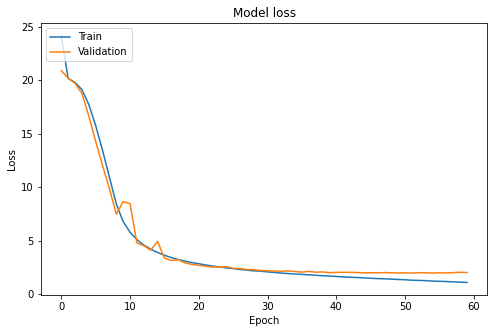

In [30]:
# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(8,5))

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot the training history
plot_training_history(history)

# Model Performance

In [31]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [32]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 87.11%
Correct words predicted      : 73.63%


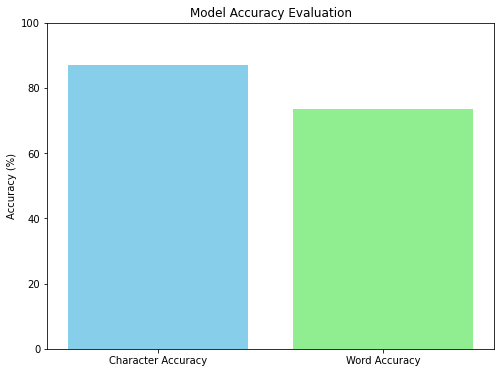

In [33]:
# Calculate accuracy based on character and word level
correct_char_percent = correct_char * 100 / total_char
correct_word_percent = correct * 100 / valid_size

# Plotting the accuracy with custom colors
plt.figure(figsize=(8, 6))
plt.bar(['Character Accuracy', 'Word Accuracy'], 
        [correct_char_percent, correct_word_percent], 
        color=['skyblue', 'lightgreen'])  # Ganti warna batang di sini
plt.ylim(0, 100)
plt.title('Model Accuracy Evaluation')
plt.ylabel('Accuracy (%)')
plt.show()

# Character Error Rate (CER) + Word Error Rate (WER)

- **CER** → measures the percentage of character errors in the predictions compared to the ground truth labels.  
- **WER** → measures the percentage of word errors in the predictions compared to the ground truth labels, including differences in word order and misrecognized words.

The smaller the **CER** and **WER** values, the better the model's performance in recognizing handwriting.


In [34]:
def calculate_cer(gt_texts, pred_texts):
    """
    Calculate the Character Error Rate (CER) between ground truth texts and predicted texts.
    """
    total_errors = 0
    total_chars = 0
    
    for gt, pred in zip(gt_texts, pred_texts):
        total_errors += edit_distance(gt, pred)
        total_chars += len(gt)
    
    cer = total_errors / total_chars
    return cer

def calculate_wer(gt_texts, pred_texts):
    """
    Calculate the Word Error Rate (WER) between ground truth texts and predicted texts.
    """
    total_errors = 0
    total_words = 0
    
    for gt, pred in zip(gt_texts, pred_texts):
        total_errors += edit_distance(gt.split(), pred.split())
        total_words += len(gt.split())
    
    wer = total_errors / total_words
    return wer

def edit_distance(s1, s2):
    """
    Calculate the Levenshtein distance between two strings.
    """
    if len(s1) < len(s2):
        return edit_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

ground_truths = valid.loc[:valid_size, 'IDENTITY'].tolist()
predictions = prediction

cer = calculate_cer(ground_truths, predictions)
wer = calculate_wer(ground_truths, predictions)

print('Character Error Rate (CER): {:.2f}%'.format(cer * 100))
print('Word Error Rate (WER): {:.2f}%'.format(wer * 100))

Character Error Rate (CER): 7.66%
Word Error Rate (WER): 26.89%


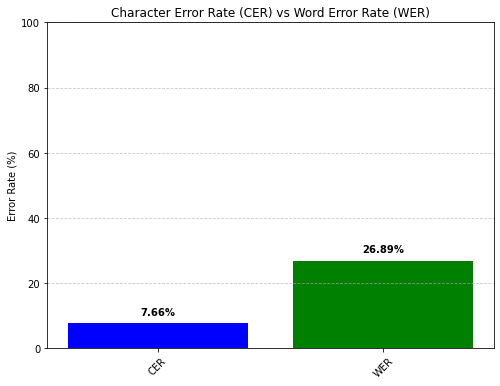

In [35]:
cer_values = [cer]  # CER value
wer_values = [wer]  # WER value
labels = ['CER', 'WER']

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(labels, [cer * 100, wer * 100], color=['blue', 'green'])
plt.ylim(0, 100)  # Set y-axis limit from 0% to 100%
plt.ylabel('Error Rate (%)')
plt.title('Character Error Rate (CER) vs Word Error Rate (WER)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate([cer * 100, wer * 100]):
    plt.text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

# Model Testing

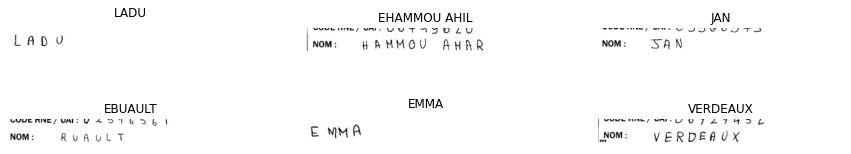

In [36]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(100,106):
    ax = plt.subplot(2, 3, i - 100 + 1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

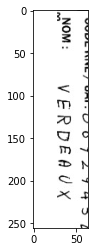

In [37]:
im = cv2.imread('/kaggle/input/handwriting-recognition/test_v2/test/TEST_0020.jpg', cv2.IMREAD_GRAYSCALE)
im = preprocess(im)
plt.imshow(image, cmap='gray')


In [38]:
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
num_to_label(decoded[0])

'VERDEAUX'

# Save model

In [39]:
model_final.save('best_model.h5')

# Inference Code

In [ ]:
model.load_weights("/kaggle/input/weights/best_model.h5")
print("✅ Weights loaded successfully!")


In [ ]:
# Step 1: Define your inference model exactly as before
input_data = Input(shape=(256, 64, 1), name='input')

# CNN blocks
inner = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)

inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2))(inner)
inner = Dropout(0.3)(inner)

inner = Reshape(target_shape=((64, 1024)))(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal')(inner)

inner = Bidirectional(LSTM(256, return_sequences=True))(inner)
inner = Bidirectional(LSTM(256, return_sequences=True))(inner)

inner = Dense(num_of_characters, kernel_initializer='he_normal')(inner)
y_pred = Activation('softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)

# Step 2: Load weights (NOT full model)
model.load_weights("/kaggle/input/weights/best_model.h5")
print("✅ Weights loaded into inference model")


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape)


In [ ]:
'''
0 input [(None, 256, 64, 1)]
1 conv2d_3 (None, 256, 64, 32)
2 batch_normalization_3 (None, 256, 64, 32)
3 activation_3 (None, 256, 64, 32)
4 max_pooling2d_3 (None, 128, 32, 32)
5 conv2d_4 (None, 128, 32, 64)
6 batch_normalization_4 (None, 128, 32, 64)
7 activation_4 (None, 128, 32, 64)
8 max_pooling2d_4 (None, 64, 16, 64)
9 dropout_2 (None, 64, 16, 64)
10 conv2d_5 (None, 64, 16, 128)
11 batch_normalization_5 (None, 64, 16, 128)
12 activation_5 (None, 64, 16, 128)
13 max_pooling2d_5 (None, 64, 8, 128)
14 dropout_3 (None, 64, 8, 128)
15 reshape_1 (None, 64, 1024)
16 dense_1 (None, 64, 64)
17 bidirectional_2 (None, 64, 512)
18 bidirectional_3 (None, 64, 512)
19 dense_2 (None, 64, 30)
20 activation_6 (None, 64, 30)

'''